In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

/Users/muraoka/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.show()

## 動作の確認
まずは5量子ビットでグローバーのアルゴリズムを実装し、動作を確認してみる。

全ての状態の重ね合わせ状態$\ket{s}$は状態$\ket{0 \cdots 0}$の全てのビッチにアダマールゲートを作用させることで作れる

### 全ての状態の重ね合わせ状態$| s \rangle = \frac{1}{\sqrt{N}} \sum_x | x \rangle$を用意する。

初期状態$| 0 \cdots 0 \rangle$に対して全ての量子ビットにアダマールゲート$H$をかける。

$$
    (H \otimes \cdots \otimes H)\ket{0 \cdots 0} = \frac{1}{(\sqrt{2})^n}(\ket{0} + \ket{1}) \otimes \cdots \otimes (\ket{0} + \ket{1}) = \ket{s}
$$

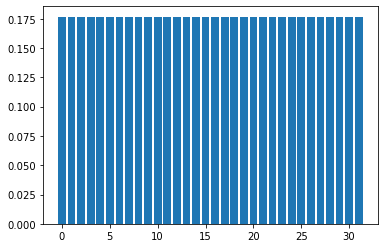

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [4]:
a = np.sqrt(2)
hoge = 1 / a
piyo = hoge ** nqubits
print(hoge)
print(piyo)

0.7071067811865475
0.1767766952966368


### オラクル$U_w$（界に対する反転操作）を作用させる

「入力$\ket{x}$に対して$x$が解なら$-1$をかけて位相を反転し、解でないなら何もしない」という演算を考えることにする。

$$
    U_w = I - 2\sum_{w \in \text{解}} \ket{w}\bra{w} \\
    U_w \ket{x} = \left\{
\begin{array}{ll}
\ket{x} (\text{x is not solution}) \\
 - \ket{x} (\text{x is solution})
\end{array}
\right.
$$
と定義する。入力が解である時にだけ位相を反転させるので、オラクル$U_w$は「解に対する反転操作」と呼ばれる。

次にオラクル$U_w$を作る。ここでは、$\ket{1 \cdots 1}$を解として設定し、$\ket{1 \cdots 1}$のみに位相(-1)をつける演算子を作る。



このような演算子は、「0番目から`nqubits`-1番目までの量子ビットが全て1の場合に`nqubits`番目の量子ビットに$Z$ゲートを作用させる演算子」として実装できる。


In [5]:
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits - 1))
    # i - th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits - 1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [6]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


## $\ket{s}$を対象軸にした反転操作$U_s$を作用させる。

ステップ2では解に対する反転操作を考えたが、ステップ3では全ての状態の重ね合わせ$\ket{s}$を対象じくにした反転操作$U_s$を作用させる。
$$
    U_s = 2 \ket{s}\bra{s} - I
$$

この演算子は、入力状態$\ket{\psi} = a \ket{s} + b \ket{s_{\perp}}$($\ket{s_{\perp}}$は$\ket{s}$に直行するベクトル)に対して、
$$
    U_s \ket{\psi} = a \ket{s} - b \ket{s_{\perp}}
$$
と作用し、$\ket{s_{\perp}}$に比例する部分の位相だけを反転する

同様に、$\ket{s}$を対象軸にした反転$U_s$を作る。
以下の式が成り立つことを使う。

$$
U_s = 2 \ket{s}\bra{s} - I = H^{\otimes n}(2 \ket{0 \cdots 0}\bra{0 \cdots 0} - I)H^{\otimes n}

In [7]:
from re import U


def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits - 1, 2 * np.pi)))
    U_s.add_gate(X(nqubits - 1))
    ## 全てのi-th　qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits - 1))
    for i in range(nqubits - 1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate(CnZ)
    U_s.add_gate(X(nqubits - 1))

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

それでは、$U_s, U_w$を一回だけ作用させて確率分布の変化を見てみる。

全部1の状態（一番右）の確率が少し大きくなっている

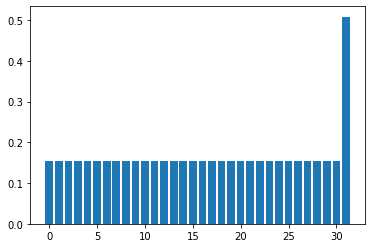

In [8]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)

これを何回か繰り返してみると、

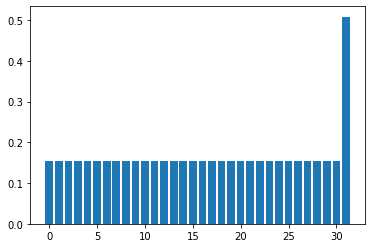

0.5082329989778305


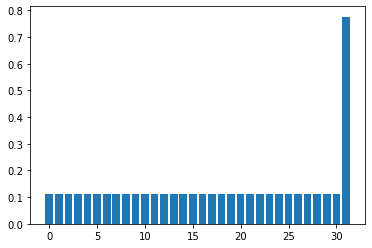

0.7761601777867947


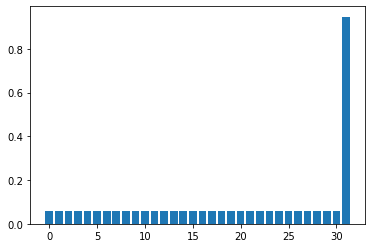

0.9470673343724091


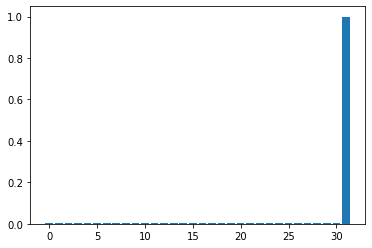

0.9995910741614723


In [9]:
## 内積を評価するために、解状態|1...1>を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2 ** nqubits - 1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state, nqubits)
    print(np.linalg.norm(inner_product(state, target_state)))

$k = 4$回ほどの繰り返しで、ほぼ確率$1$で解を得ることができた。

### 最適な回数の見積もり

$U_s U_w$を作用させる回数$k$がどのくらいになるか評価する。

$(U_s U_w)^k \ket{s}$が解に最も近くなるのは、$\frac{2(k + 1)\theta}{2}$が$\frac{\pi}{2}$に近くなる時、すなわち$k$が、
$$
R = \text{ClosestInteger}(\frac{\pi}{2\theta} - \frac{1}{2})
$$
の時である。ここで、ClosestInteger(...)は...に最も近い整数を表す。

 Rの上限を評価する。$\theta > 0$について成り立つ式、
 $$
\frac{\theta}{2} \geq \sin(\frac{\theta}{2}) = \sqrt{\frac{M}{N}}
 $$
 を使うと、
 $$
R \leq \left( \frac{\pi}{2\theta} - \frac{1}{2} \right) + 1 = \frac{\pi}{2 \theta} + \frac{1}{2} \leq \frac{\pi}{4} \sqrt{\frac{N}{M}} + \frac{1}{2}
 $$

となる。

In [10]:
def estimate_the_optimal_number_of_times(nqubits):
    pi = np.pi
    MNsqrt = np.sqrt(2 ** nqubits)
    result = (pi / 4) * MNsqrt + 1/2
    return result

In [11]:
estimate_the_optimal_number_of_times(5)

4.942882938158366

次に、`nqubits`をもう少し大きくして、$k$に対する出力確率の振る舞いを見てみる。

maximal probabillity  9.997306e-01 is obrained at k = 25


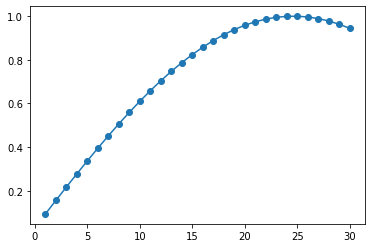

In [12]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

## 内積を評価するために、解状態|1...1>を作成する
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2 ** nqubits - 1) ## 2進数で1...1

## グローバーのアルゴリズム
Hadamard = make_Hadamard(nqubits)
U_w = make_U_w(nqubits)
U_s = make_U_s(nqubits)

result = []

state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)
for k in range(30):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    # show_distribution(state.nqubits)
    result.append(np.linalg.norm(inner_product(state, target_state)))

max_k = np.argmax(result)
print(f"maximal probabillity {result[max_k]: 5e} is obrained at k = {max_k + 1}")

plt.plot(np.arange(1, 30 + 1), result, "o-")

# // サインカーブ


In [13]:
estimate_the_optimal_number_of_times(10)

25.632741228718345

$k = 25$回でほぼ確率が1でtarget状態が得られている。
また、確率の$k$依存性は、「幾何学的な説明」の箇所で見た方に、サイン関数になっている。

この処理は関数化できそうなので、関数化してみた。

maximal probabillity  7.071068e-01 is obrained at k = 1
maximal probabillity  1.000000e+00 is obrained at k = 1
maximal probabillity  9.998932e-01 is obrained at k = 6
maximal probabillity  9.997817e-01 is obrained at k = 15


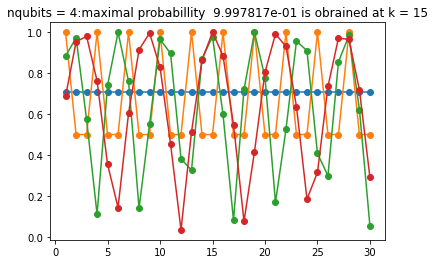

In [14]:
def grover(nqubits):
    state = QuantumState(nqubits)
    state.set_zero_state()
    
    ## 内積を評価するために、解状態|1...1>を作成する
    
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) ## 2進数で1...1
    
    # グローバーのアルゴリズム
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(30):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state.nqubits)
        result.append(np.linalg.norm(inner_product(state, target_state)))

    max_k = np.argmax(result)
    text = f"maximal probabillity {result[max_k]: 5e} is obrained at k = {max_k + 1}"
    # print(f"maximal probabillity {result[max_k]: 5e} is obrained at k = {max_k + 1}")
    print(text)
    plt.title(f'nqubits = {nqubits}:' + text)

    plt.plot(np.arange(1, 30 + 1), result, "o-")
    
grover(1)
grover(2)
grover(3)
grover(4)

最後に、解を見つけるために必要な$k$が量子ビット数についてどのように振る舞うか見てみる。

In [15]:
# FIXME 計算がうまくいかないため、コメントアウト

result = []
min_nqubits = 6
max_nqubits = 16
for nqubits in range(min_nqubits, max_nqubits+1, 2):
    ## 回路の準備
    Hadamard = make_Hadamard(nqubits)
    U_w= make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    ## 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)

    ## 確率が減少を始めるまで U_s U_w をかける
    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 and num_iter <= 1000:
        num_iter += 1
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else:
            flag = 1
    result.append( [nqubits, num_iter, suc_prob] )
    print(f"nqubits={nqubits}, num_iter={num_iter}, suc_prob={suc_prob:5e}")

nqubits=6, num_iter=7, suc_prob=9.526013e-01
nqubits=8, num_iter=13, suc_prob=9.930691e-01
nqubits=10, num_iter=26, suc_prob=9.963280e-01
nqubits=12, num_iter=51, suc_prob=9.992534e-01
nqubits=14, num_iter=101, suc_prob=9.998851e-01
nqubits=16, num_iter=202, suc_prob=9.999368e-01


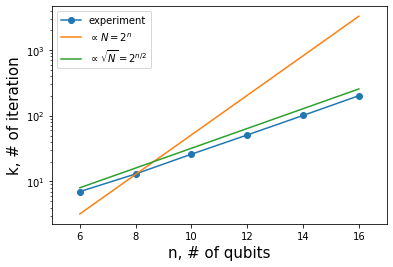

In [16]:
result_array = np.array(result)

plt.xlim(min_nqubits-1, max_nqubits+1)
plt.xlabel("n, # of qubits", fontsize=15)
plt.ylabel("k, # of iteration", fontsize=15)
plt.semilogy(result_array[:,0], result_array[:,1], "o-", label="experiment")
plt.semilogy(result_array[:,0], 0.05*2**result_array[:,0], "-", label=r"$\propto N=2^n$")
plt.semilogy(result_array[:,0], 2**(0.5*result_array[:,0]), "-", label=r"$\propto \sqrt{N}=2^{n/2}$")
plt.legend(fontsize=10)

# 1量子ビットから10量子ビットまでの最適な回数
1量子ビットから10量子ビットまでの最適な回数をグラフで表す。

maximal probabillity  7.071068e-01 is obrained at k = 1
maximal probabillity  1.000000e+00 is obrained at k = 1
maximal probabillity  9.998932e-01 is obrained at k = 6
maximal probabillity  9.997817e-01 is obrained at k = 15
maximal probabillity  9.995911e-01 is obrained at k = 4
maximal probabillity  9.982914e-01 is obrained at k = 6
maximal probabillity  9.997649e-01 is obrained at k = 26
maximal probabillity  9.999735e-01 is obrained at k = 12
maximal probabillity  9.997240e-01 is obrained at k = 17
maximal probabillity  9.997306e-01 is obrained at k = 25


<Figure size 576x360 with 0 Axes>

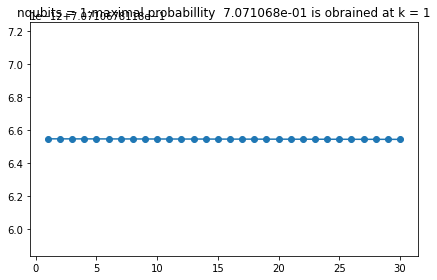

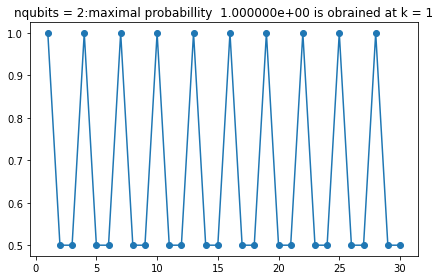

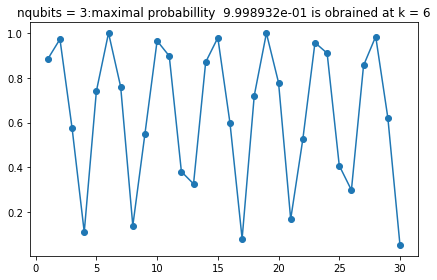

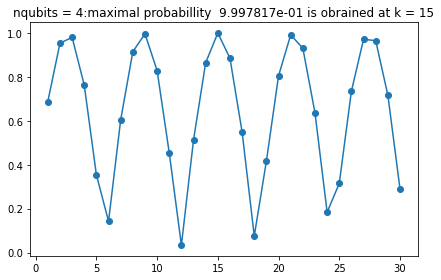

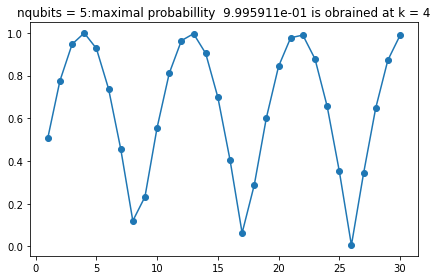

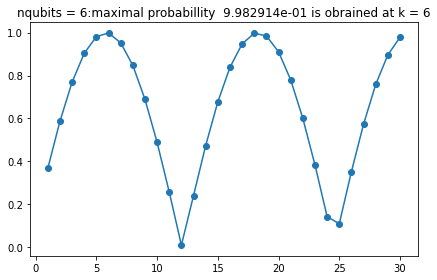

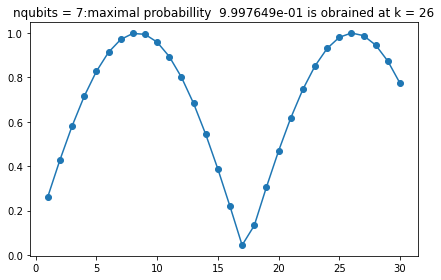

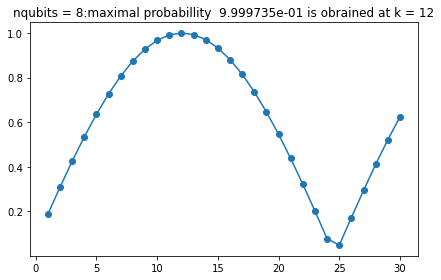

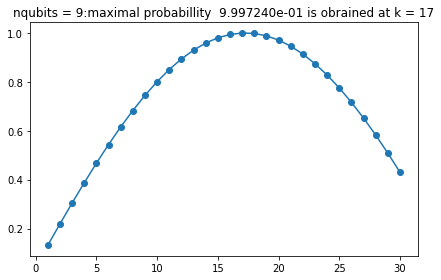

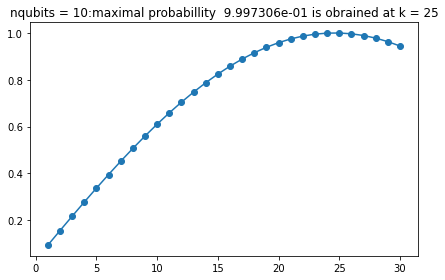

In [17]:
from matplotlib.pyplot import tight_layout

grover_Array = []
fig = plt.figure(figsize=(8, 5))
for i in range(1, 11):
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'grover nqubit={i}')

    grover_i = grover(i)

### 出力が理想的でないもの
| 量子ビット数 |  理想値  | 実験値 |
| :----------: |:-----:| :----: |
| 3            |   2   | 6      |
| 4            |   3   | 15     |
| 7            |   8   | 26     |


In [18]:
ideal_nqubits_3 = estimate_the_optimal_number_of_times(3)
ideal_nqubits_4 = estimate_the_optimal_number_of_times(4)
ideal_nqubits_7 = estimate_the_optimal_number_of_times(7)

print(f'3量子ビットの理想回数：{ideal_nqubits_3}')
print(f'4量子ビットの理想回数：{ideal_nqubits_4}')
print(f'7量子ビットの理想回数：{ideal_nqubits_7}')

3量子ビットの理想回数：2.721441469079183
4量子ビットの理想回数：3.641592653589793
7量子ビットの理想回数：9.385765876316732


 TODO:7量子ビットの場合、オラクルの理想回数は$k = 8$に見えるが、計算だと$k = 9$になる。
 

### 疑問点
- なぜ、理想値と実験値が異なるのか
- 実験値の回数の方が解に最も近くなる。

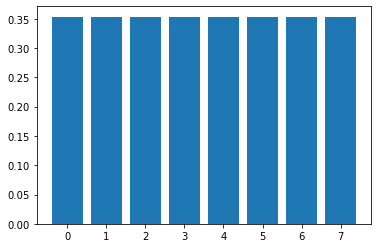

In [19]:
# FIXME:関数化させる
# 初期状態の準備
nqubits = 3
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [20]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]


In [21]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
# show_distribution(state, nqubits)

1回目
0.8838834764831837


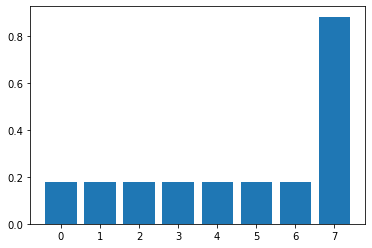

2回目
0.9722718241315015


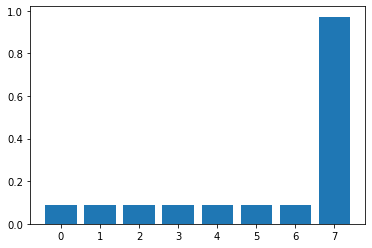

3回目
0.5745242597140687


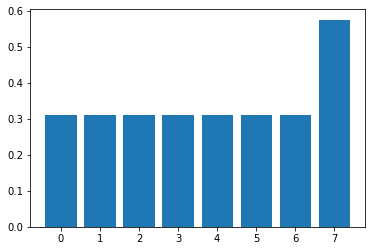

4回目
0.11048543456039785


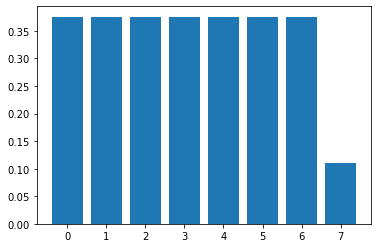

5回目
0.7402524115546648


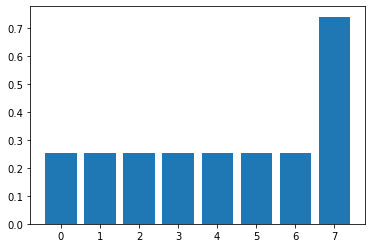

6回目
0.999893182771599


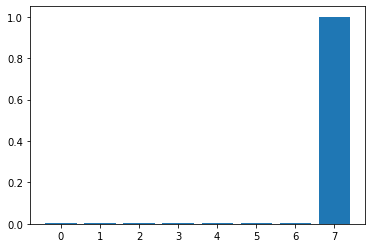

7回目
0.7595873626027337


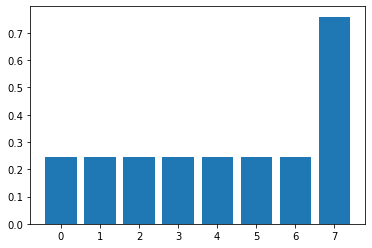

In [22]:
## 内積を評価するために、解状態|1...1>を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2 ** nqubits - 1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

for i in range(7):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)

    print(f'{i + 1}回目') 
    print(np.linalg.norm(inner_product(state, target_state)))
    show_distribution(state, nqubits)

Q.より1に近づく回数を求めるにはどうすれば良いか？